# Getting Organized

In [1]:
import numpy as np
np.random.seed(42)
import os

# Plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Pandas
import pandas as pd

# RYO
from lib.ts_decomposition.ts_decomp import TsDecomp


# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [6]:
# Config
PROJECT_ROOT_DIR = "."
PROJECT_DATA_DIR = os.path.join(PROJECT_ROOT_DIR, 'data')


# Save Images
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")

# File
FILE_NAME = "energydata_complete.csv"

In [7]:
# Util Funcs
def load_data(file_name, data_path="."):
    csv_path = os.path.join(data_path, file_name)
    return pd.read_csv(csv_path)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


In [8]:
energy_data = load_data(FILE_NAME, PROJECT_DATA_DIR)
energy_series = TsDecomp(energy_data, "date")
energy_series.base.tail()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,...,23.2,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,...,23.2,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,...,23.2,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,...,23.2,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784
19734,2016-05-27 18:00:00,430,10,25.500000,46.600000,25.264286,42.971429,26.823333,41.156667,24.7,...,23.2,46.8450,22.200000,755.2,57.000000,4.000000,27.000000,13.200000,34.118851,34.118851


In [9]:
energy_series.day_of_week_class()
energy_series.weekend_weekday_class()

energy_series.split_ts(20)

energy_series.base.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,day_of_week_class,weekend_weekday_class
count,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,...,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000
mean,98.024449,4.314036,21.152184,40.037455,19.631593,40.556150,21.588743,39.339250,20.148708,38.917235,...,5.855215,755.401923,81.834642,4.276856,38.672314,2.731101,25.025954,25.025954,2.980111,0.276793
std,105.198291,8.363499,1.214241,3.593212,1.516601,3.396775,1.498186,3.205111,1.508309,4.276400,...,4.129179,7.778350,12.920004,2.555565,12.402705,3.523068,14.521067,14.521067,1.980390,0.447427
min,10.000000,0.000000,16.790000,27.733333,16.100000,25.763333,17.200000,32.626667,15.100000,27.660000,...,-5.000000,729.300000,31.000000,0.000000,1.000000,-6.600000,0.005322,0.005322,0.000000,0.000000
25%,50.000000,0.000000,20.500000,37.290000,18.566667,38.266667,20.500000,36.966667,19.200000,35.462500,...,2.950000,750.600000,73.333333,2.000000,29.000000,0.400000,12.585736,12.585736,1.000000,0.000000
50%,60.000000,0.000000,21.290000,39.530000,19.566667,40.560000,21.633333,38.633333,20.260000,38.290000,...,5.800000,755.933333,85.333333,4.000000,40.000000,2.757143,24.917394,24.917394,3.000000,0.000000
75%,100.000000,10.000000,22.000000,42.722708,20.600000,43.126667,22.600000,41.790000,21.200000,41.863333,...,8.800000,761.366667,92.000000,6.000000,40.000000,5.200000,37.733747,37.733747,5.000000,1.000000
max,1080.000000,70.000000,24.100000,63.360000,24.600000,56.026667,27.600000,50.163333,23.760000,51.090000,...,19.700000,772.300000,100.000000,14.000000,66.000000,11.400000,49.996530,49.996530,6.000000,1.000000


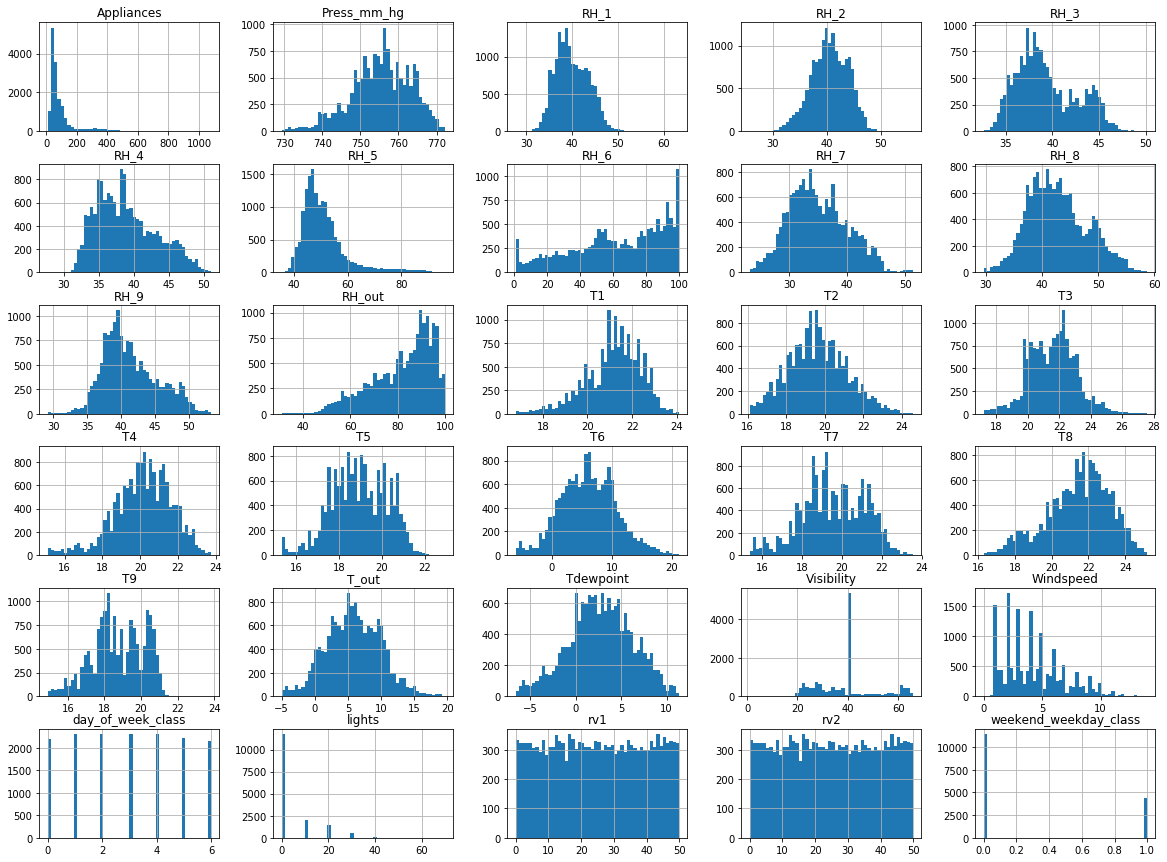

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
energy_series.base.hist(bins=50, figsize=(20,15))
plt.show()

# Now we can observe (read: clean)

Appliances: Standard Dev is high compared to mean, especially factoring in min and max. So, we will have a big initial hump (maybe close to localized normal), and some BIG positive outliers

Lights: 
    - a lot of time on 0, maybe we can catogorize/bin this val
    - Remove Zeroes and take a hist? => appliances?
    

Visibility: one huge bin?

Windspeed: Levels?

Wait to label until labels
Temps:
    - "Spikey bins"? => Equilibrium point/level?
    - otherwise center lump
    
Humidity:
    - left side lump
    - but one is flat?
    - definitely some cutoff
    

# TODO: 
Switch to TS Object from lib
Make the influx cutoff from there

Two sided structure: 
    - dataframe for Jupyter Analytics
    - Array for implimented ML algorithms
    

# Appliance Energy

## Stationality

## DF Test
https://machinelearningmastery.com/time-series-data-stationary-python/